### Proportion of UK area at different severity ratings over time

###### Preliminaries

In [2]:
import scipy.stats
import math
import xarray
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import warnings
import matplotlib as mpl
import warnings
import cmasher as cmr
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter


In [3]:
def get_lat_lon_ukcp(grid_lat,grid_lon):
    rlon = grid_lon * np.pi/180
    rlat = grid_lat * np.pi/180
    
    theta = -(90 - 39.25) * np.pi/180
    phi = -(180 - 162) * np.pi/180
    x = np.outer(np.cos(rlat),np.cos(rlon))
    y = np.outer(np.cos(rlat),np.sin(rlon))
    z = np.outer(np.sin(rlat),np.ones(len(rlon)))

    x_new = np.cos(theta) * np.cos(phi) * x + np.sin(phi) * y + np.sin(theta) * np.cos(phi) * z
    y_new = -np.cos(theta) * np.sin(phi) * x + np.cos(phi) * y - np.sin(theta) * np.sin(phi) * z
    z_new = -np.sin(theta) * x + np.cos(theta) * z
    
    lons = np.arctan(np.divide(y_new, x_new)) * 180/np.pi
    lats = np.arcsin(z_new) * 180/np.pi
    
    return lons,lats

In [4]:
def get_cordex_addresses():
    models = pd.read_csv('cordex_models.txt', sep='\t')

    # Getting file strings:
        # Directories:
    root = '/data/met/ukcordex/'
    directories = [root + models['GCM'][i] + '/' +
                   models['RCM'][i] + '/' +
                   models['Ensemble'][i] + '/dmo/'
                   for i in range(models.shape[0])]

        # Filenames:
    #feat. clunky for loops and error handling!
    tas_files  = []
    hurs_files = []
    pr_files   = []
    wind_files = []
    err_indexs = []
    print(type(err_indexs))
    for i in range(models.shape[0]):
        try:
            for f_name in os.listdir(directories[i]):
                if f_name.startswith('tas_'):
                    tas_files.append(str(f_name))
                if f_name.startswith('hurs_'):
                    hurs_files.append(str(f_name))
                if f_name.startswith('sfcWind_'):
                    wind_files.append(str(f_name))
                if f_name.startswith('pr_'):
                    pr_files.append(str(f_name))

        except OSError as error:
            print(f'Inelligible directory at: {directories[i]}')
            err_indexs.append(int(i))


    for i in range(len(err_indexs)):
        del directories[err_indexs[i]]
    
    return directories,tas_files,hurs_files,wind_files,pr_files

###### Main Section

In [ ]:
# Loading FWI and calculating percentiles:
directories,tas_files,hurs_files,wind_files,pr_files = get_cordex_addresses()

fwi_thresholds = np.empty((len(directories),5))

tas_data  = xarray.open_dataset(directories[1] + tas_files[1], engine = "netcdf4")
years = np.array(pd.to_datetime(np.array(tas_data.time)).year)
months = np.array(pd.to_datetime(np.array(tas_data.time)).month)
del tas_data
summer_indices = np.array([])
for i in range(1981,2001,1): # years
    year_inds = np.where(years == i)
    summer_inds=np.concatenate((np.where(months == 6)[0],
                                np.where(months == 7)[0],
                                np.where(months == 8)[0]),
                                axis = 0)
    inds = np.intersect1d(year_inds,summer_inds)
    summer_indices = np.append(summer_indices,inds).astype(int)


for i in range(1,len(directories)+1):
    print(f'Model {i}')
    fwi_model_i_data = np.load(f'/data/met/fwi/ukcordex_new_fwi_{i}.npy')[0,summer_indices,:,:].flatten()
    plt.hist(fwi_model_i_data)
    fwi_thresholds[i-1,:] = np.percentile(fwi_model_i_data,[90 , 99 , 99.9 , 99.99 , 99.999])
    del fwi_model_i_data

print(fwi_thresholds)

In [ ]:
print(fwi_thresholds[1:49,:].shape) # Getting rid of model 1 due to corrupted hurs
np.save('/home/theo/outdata/fwi_thresholds',fwi_thresholds[1:49,:])

In [ ]:
fwi_thresholds = np.load('/home/theo/outdata/fwi_thresholds.npy')
print(fwi_thresholds.shape)
thresholds = [90,99,99.9,99.99,99.999]


for i in range(5):
   
    shape, location, scale = scipy.stats.lognorm.fit(fwi_thresholds[:,i])
    #x = np.linspace(scipy.stats.lognorm.ppf(0.00001, shape),scipy.stats.lognorm.ppf(0.99999, shape), 100000)
    x = np.linspace(0,2*np.max(fwi_thresholds[:,i]),100000)
    cdf = scipy.stats.lognorm.cdf(x, shape, location, scale)
    pdf = scipy.stats.lognorm.pdf(x, shape, location, scale)
    # 95% interval:
    arg_lo = np.argmin(np.absolute(cdf-0.025))
    arg_hi = np.argmin(np.absolute(cdf-0.975))
    fwi_95_lo = x[arg_lo]
    fwi_95_hi = x[arg_hi]
    out_indices_95 = np.where(fwi_thresholds[:,i]>fwi_95_hi)[0]
    out_indices_95 = np.append(out_indices_95,np.where(fwi_thresholds[:,i]<fwi_95_lo)[0])
    # 99% interval:
    arg_lo = np.argmin(np.absolute(cdf-0.005))
    arg_hi = np.argmin(np.absolute(cdf-0.995))
    fwi_99_lo = x[arg_lo]
    fwi_99_hi = x[arg_hi]
    out_indices_99 = np.where(fwi_thresholds[:,i]>fwi_99_hi)[0]
    out_indices_99 = np.append(out_indices_99,np.where(fwi_thresholds[:,i]<fwi_99_lo)[0])
    # 99.9% interval:
    arg_lo = np.argmin(np.absolute(cdf-0.0005))
    arg_hi = np.argmin(np.absolute(cdf-0.9995))
    fwi_999_lo = x[arg_lo]
    fwi_999_hi = x[arg_hi]
    out_indices_999 = np.where(fwi_thresholds[:,i]>fwi_999_hi)[0]
    out_indices_999 = np.append(out_indices_999,np.where(fwi_thresholds[:,i]<fwi_999_lo)[0])
    
    
    plt.figure()
    plt.title(f'{thresholds[i]}th Percentile')
    plt.hist(fwi_thresholds[:,i])
    plt.plot(x,49*pdf)
    plt.show()
    
    print(fwi_thresholds[:,i][out_indices_95[1]])
    
    print(f'{thresholds[i]}th Percentile\n')
    
    print(f'Mean value: {np.mean(fwi_thresholds[:,i])}')
    
    print(f'\n95% confidence threshold: {fwi_95_lo} to {fwi_95_hi}')
    print(f'Values outside of bounds:')
    if len(out_indices_95)>0:
        for j in range(len(out_indices_95)):
            print(f'Model {out_indices_95[j]}, with value {fwi_thresholds[:,i][out_indices_95[j]]}')
    else:
        print('None')
          
    print(f'\n99% confidence threshold: {fwi_99_lo} to {fwi_99_hi}')
    print(f'Values outside of bounds:')
    if len(out_indices_99)>0:
        for j in range(len(out_indices_99)):
            print(f'Model {out_indices_99[j]}, with value {fwi_thresholds[:,i][out_indices_99[j]]}')
    else:
        print('None')
        
    print(f'\n99.9% confidence threshold: {fwi_999_lo} to {fwi_999_hi}')
    print(f'Values outside of bounds:')
    if len(out_indices_999)>0:
        for j in range(len(out_indices_999)):
            print(f'Model {out_indices_999[j]}, with value {fwi_thresholds[:,i][out_indices_999[j]]}')
    else:
        print('None') 
        
    

In [ ]:
# The above is all legit and therefore we won't eliminate any models from the sample
# Excpet model_1 which has already been eliminated... 

thresholds = [90,99,99.9,99.99,99.999]
fwi_bounds = np.array([[90,5.804893137306259],
                       [99, 13.581170681055468],
                       [99.9,22.42854134637913],
                       [99.99,31.908170932956054],
                       [99.999,41.17097794179168]])
np.save('/home/theo/outdata/fwi_bounds',fwi_bounds)
print(fwi_bounds.shape)

In [ ]:
def earth_radius(lat):
    # From: https://towardsdatascience.com/the-correct-way-to-average-the-globe-92ceecd172b7
    a = 6378137
    b = 6356752.3142
    e2 = 1 - (b**2/a**2)
    lat = np.deg2rad(lat)
    lat_gc = np.arctan( (1-e2)*np.tan(lat) )

    # radius equation
    # see equation 3-107 in WGS84
    r = (
        (a * (1 - e2)**0.5) 
         / (1 - (e2 * np.cos(lat_gc)**2))**0.5 
        )

    return r


def area_grid(lats,lons):
    # Adapted rom: https://towardsdatascience.com/the-correct-way-to-average-the-globe-92ceecd172b7
    R = earth_radius(lats)
    dlat = np.deg2rad(np.gradient(lats, axis=0))
    dlon = np.deg2rad(np.gradient(lons, axis=1))
    dy = dlat * R
    dx = dlon * R * np.cos(np.deg2rad(lats))
    area_weights = dy * dx
    
    return area_weights

In [ ]:
region_data  = xarray.open_dataset('/home/theo/data/ukcp18-uk-land-region-rll.nc')
region_mask = region_data.admin_region
region_mask = np.nan_to_num(region_mask)
ids = ['All UK', 'East Midlands', 'East of England',
       'East Scotland','London','North-East England',
       'North Scotland','North-West England',
       'South-East England','South-West England',
       'West Midlands','West Scotland',
       'Yorkshire and Humberside',
       'Channel Islands',
       'Isle of Man',
       'Northern Ireland','Wales']
save_ids = ['uk', 'e_mdls', 'e_eng',
       'e_scot','ldn','ne_eng',
       'n_scot','nw_eng',
       'se_eng','sw_eng',
       'w_mdls','w_scot',
       'yorks_n_hums',
       'chnl_isl',
       'isl_man',
       'n_irln','wales']

In [ ]:
directories,tas_files,hurs_files,wind_files,pr_files = get_cordex_addresses()
mask = np.logical_not(region_mask == 0).astype(float)
mask[mask == 0] = np.nan
model_fwi = np.empty((6,49))    

for k in range(1,3):
    try:
        tas_data_a  = xarray.open_dataset(directories[k] + tas_files[k], engine = "netcdf4")
        lats = np.array(tas_data_a.latitude)
        lons = np.array(tas_data_a.longitude)
    except:
        tas_data_a  = xarray.open_dataset(directories[k] + tas_files[k], engine = "netcdf4")
        lats = np.array(tas_data_a.lat)
        lons = np.array(tas_data_a.lon)
    w = mask * area_grid(lats,lons)/10000**2 # Weightings
    plt.figure()
    plt.imshow(w)
    plt.figure()
    plt.hist(w.flatten()/(np.nanmean(w)),bins=100,range=(0.95,1.05))
    print(np.nanmax(w.flatten()/(np.nanmean(w))))
    print(np.nanmin(w.flatten()/(np.nanmean(w))))

###### Making CORDEX data

In [ ]:
# CORDEX WEIGHTED DATA
directories,tas_files,hurs_files,wind_files,pr_files = get_cordex_addresses()
tas_data  = xarray.open_dataset(directories[1] + tas_files[1], engine = "netcdf4")
years = np.array(pd.to_datetime(np.array(tas_data.time)).year)
months = np.array(pd.to_datetime(np.array(tas_data.time)).month)
del tas_data


# Plot data: affected_area.shape = (time_bins,risk_level,region) = (10,6,17) 
# [0-90, 90-99, 99-99.9, 99.9-99.99, 99.99-99.999, 99.999-100]

fwi_area = np.empty((10,6,17))

In [ ]:
fwi_area_dec = np.empty((10,6,17))
for i in range(10):
    print(f'Decade {i+1}')
    summer_indices = np.array([])
    for q in range(1981+10*i,1991+10*i,1):
        year_inds = np.where(years == q)
        summer_inds=np.concatenate((np.where(months == 6)[0],
                                    np.where(months == 7)[0],
                                    np.where(months == 8)[0]),
                                    axis = 0)
        inds = np.intersect1d(year_inds,summer_inds)
        summer_indices = np.append(summer_indices,inds).astype(int)

    
    for j in range(0,1):#17):
        print(f'Region Code: {j}')
        mask = np.logical_not(region_mask == 0).astype(int)
        model_fwi = np.empty((6,49))    
        
        for k in range(1,49):
            try:
                tas_data_a  = xarray.open_dataset(directories[k] + tas_files[k], engine = "netcdf4")
                lats = np.array(tas_data_a.latitude)
                lons = np.array(tas_data_a.longitude)
            except:
                tas_data_a  = xarray.open_dataset(directories[k] + tas_files[k], engine = "netcdf4")
                lats = np.array(tas_data_a.lat)
                lons = np.array(tas_data_a.lon)
            w = mask * area_grid(lats,lons)/10000**2 # Weightings
            w[w == 0] = np.nan                       # Setting the 0 values of the grid to nan
            #print(f'Weightings shape: {w.shape}')
            #print(f'Weightings range: {np.nanmin(w)} to {np.nanmax(w)}')
            fwi_model_k_data = np.load(f'/data/met/fwi/ukcordex_new_fwi_{k+1}.npy')[0,summer_indices,:,:]
            #print(f'Model "k", FWI shape: {fwi_model_k_data.shape}')
            #print(f'Model "k", FWI range: {np.unique(fwi_model_k_data)}')
            
            model_fwi_5_k = np.einsum('ijk,jk->ijk', (fwi_model_k_data > fwi_bounds[4,1]).astype(int), w)
            model_fwi_4_k = np.einsum('ijk,jk->ijk', (fwi_model_k_data > fwi_bounds[3,1]).astype(int), w)
            model_fwi_3_k = np.einsum('ijk,jk->ijk', (fwi_model_k_data > fwi_bounds[2,1]).astype(int), w)
            model_fwi_2_k = np.einsum('ijk,jk->ijk', (fwi_model_k_data > fwi_bounds[1,1]).astype(int), w)
            model_fwi_1_k = np.einsum('ijk,jk->ijk', (fwi_model_k_data > fwi_bounds[0,1]).astype(int), w)
            model_fwi_0_k = np.einsum('ijk,jk->ijk', (fwi_model_k_data > 0).astype(int), w)
            
            #print(f'Outarray shape: {model_fwi_5_k.shape}')
            #print(f'Outarray range: {np.nanmin(model_fwi_5_k)} to {np.nanmax(model_fwi_5_k)}')
            
            model_fwi[5,k] = np.nansum(model_fwi_5_k) / np.count_nonzero(~np.isnan(model_fwi_5_k))
            model_fwi[4,k] = np.nansum(model_fwi_4_k) / np.count_nonzero(~np.isnan(model_fwi_4_k))
            model_fwi[3,k] = np.nansum(model_fwi_3_k) / np.count_nonzero(~np.isnan(model_fwi_3_k))
            model_fwi[2,k] = np.nansum(model_fwi_2_k) / np.count_nonzero(~np.isnan(model_fwi_2_k))
            model_fwi[1,k] = np.nansum(model_fwi_1_k) / np.count_nonzero(~np.isnan(model_fwi_1_k))
            model_fwi[0,k] = np.nansum(model_fwi_0_k) / np.count_nonzero(~np.isnan(model_fwi_0_k))
            
            print(f'Output: {model_fwi[:,k]}')
            
            #model_fwi[5,k] = np.sum(np.multiply((fwi_model_k_data > fwi_bounds[4,1]).astype(int),w))
            #model_fwi[4,k] = np.sum(np.multiply((fwi_model_k_data > fwi_bounds[3,1]).astype(int),w))
            #model_fwi[3,k] = np.sum(np.multiply((fwi_model_k_data > fwi_bounds[2,1]).astype(int),w))
            #model_fwi[2,k] = np.sum(np.multiply((fwi_model_k_data > fwi_bounds[1,1]).astype(int),w))
            #model_fwi[1,k] = np.sum(np.multiply((fwi_model_k_data > fwi_bounds[0,1]).astype(int),w))
            #model_fwi[0,k] = np.sum(np.multiply((fwi_model_k_data > 0).astype(int),w))
            
            del tas_data_a,lats,lons,w,fwi_model_k_data
        
        
            #print((model_fwi[5,:]))
            #print((model_fwi[4,:]))
            #print((model_fwi[3,:]))
            #print((model_fwi[2,:]))
            #print((model_fwi[1,:]))
            #print((model_fwi[0,:]))


In [ ]:
# Building fake data:
fake_data = np.empty((6,100))

fake_data[1,:] = 1.03**np.arange(0,100) + 5*np.abs(np.random.rand(100))
fake_data[2,:] = 1.02**np.arange(0,100) + 4*np.abs(np.random.rand(100))
fake_data[3,:] = 1.01**np.arange(0,100) + 3*np.abs(np.random.rand(100))
fake_data[4,:] = 1.005**np.arange(0,100) + 2*np.abs(np.random.rand(100))
fake_data[5,:] = 1.002**np.arange(0,100) + 1*np.abs(np.random.rand(100))
fake_data[0,:] = 25 - fake_data[1,:] - fake_data[2,:] - fake_data[3,:] - fake_data[4,:] - fake_data[5,:]
fake_data = (fake_data - np.min(fake_data)) / np.max(np.sum(fake_data - np.min(fake_data),axis=0))
print(fake_data.shape)

In [ ]:
fwi_ukcp = np.load('/home/theo/outdata/2.1.outdata/ukcp18_regional_fwi_severity_by_area.npy')
print(fwi_ukcp.shape)
print(np.unique(fwi_ukcp))

In [ ]:
fwi_data = np.load('/home/theo/outdata/2.1.outdata/fwi_area_only_uk.npy')
fwi_data = fwi_data[:,1:49,:] # Looking only at the bits where I saved data

fwi_inputs = np.mean(fwi_data,axis=1)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)


# putting into decade bins:
fwi_by_dec = np.empty((6,10))
for i in range(10):
    fwi_by_dec[:,i] = np.mean(fwi_inputs[:,i*10:(i+1)*10],axis=1)

In [ ]:
fwi_data = np.load('/home/theo/outdata/2.1.outdata/fwi_area_only_uk_land.npy')
print(fwi_data[:,:,:].shape)
print(fwi_data[:,1,:])

In [ ]:
%run /home/theo/scripts/fwi_bounds_ukcp_regional.py

In [ ]:

# Mean Plot:
fwi_data = np.load('/home/theo/outdata/2.1.outdata/ukcp18_regional_fwi_severity_all_uk.npy')[:,:,0,:]
print(fwi_data.shape)
fwi_inputs = np.mean(fwi_data,axis = 1)
print(fwi_inputs.shape)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
print(sum(fwi_inputs[:,np.random.randint(0,high=99)]))
# Putting into decade bins:
fwi_by_dec = np.empty((6,10))
for i in range(10):
    fwi_by_dec[:,i] = np.mean(fwi_inputs[:,i*10:(i+1)*10],axis=1)

plot_data = fwi_by_dec

colours = ['#0A9396','#94D2BD','#E9D8A6','#EE9B00','#CA6702','#AE2012']
markers = 6*['s']
numbers = [0,90,99,99.9,99.99,99.999,100]
labels = [f'{numbers[i]} to {numbers[i+1]}%' for i in range(6)]
labels = ['Very Low','Low','Moderate','High','Very High','Extreme']
#['0-90','90-99','99-99.9','99.9-99.99','99.99-99.999','99.999-100']
handles = 6*[]


fig,ax = plt.subplots(1,2, figsize=(14, 6))
bottom = 10 * [0]
for i in range(5,-1,-1):
    ax[0].bar(1985+np.arange(10)*10,plot_data[i,:], bottom=bottom, width = 10.0, color=colours[i])
    bottom = bottom + plot_data[i,:]

ax[0].set_title('UKCP18: Change in Mean Summer Severity of FWI (All UK)', fontsize = 15)
ax[0].set_xlabel('Year', fontsize = 14)
ax[0].set_ylabel('Proportion of UK Area Affected by Severity Level', fontsize = 14)
ax[0].set_yscale('log') 
ax[0].set_ylim([0.00001,1])
handles = [mpl.lines.Line2D([], [], color=colours[i], marker='s', 
                            linestyle='None',markersize=10, 
                            label=labels[i]) for i in range(6)]

ax[1].legend(handles=handles,bbox_to_anchor=(1.07, 0.8),markerscale=2,
           title = 'Severity Rating', title_fontsize = 14,
           frameon = False, fontsize=12,
           labelspacing=1.6,loc=9)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].tick_params(labelsize=12)
ax[0].set_xlim((1980, 2080)) 


plt.tight_layout()
plt.savefig('/home/theo/final_images/2.1.images/mean/ukcp18_mean_fwi_by_area_timeseries_uk', bbox_inches='tight')

In [ ]:
# Max Plot:
fwi_data = np.load('/home/theo/outdata/2.1.outdata/ukcp18_regional_fwi_severity_all_uk.npy')[:,:,0,:]
print(fwi_data.shape)
fwi_inputs = np.max(fwi_data,axis = 1)
print(fwi_inputs.shape)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
print(sum(fwi_inputs[:,np.random.randint(0,high=99)]))
# Putting into decade bins:
fwi_by_dec = np.empty((6,10))
for i in range(10):
    fwi_by_dec[:,i] = np.mean(fwi_inputs[:,i*10:(i+1)*10],axis=1)

plot_data = fwi_by_dec

colours = ['#0A9396','#94D2BD','#E9D8A6','#EE9B00','#CA6702','#AE2012']
markers = 6*['s']
numbers = [0,90,99,99.9,99.99,99.999,100]
labels = [f'{numbers[i]} to {numbers[i+1]}%' for i in range(6)]
labels = ['Very Low','Low','Moderate','High','Very High','Extreme']
#['0-90','90-99','99-99.9','99.9-99.99','99.99-99.999','99.999-100']
handles = 6*[]
fig,ax = plt.subplots(1, figsize=(8, 6))
bottom = 10 * [0]
for i in range(5,-1,-1):
    ax.bar(1985+np.arange(10)*10,plot_data[i,:], bottom=bottom, width = 10.0, color=colours[i])
    bottom = bottom + plot_data[i,:]

plt.title('UKCP18: Change in Maximum Predicted FWI (All UK)', fontsize = 15)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Proportion of UK Area Affected by Severity Level', fontsize = 14)
ax.set_yscale('log') 
plt.ylim([0.00001,1])

handles = [mpl.lines.Line2D([], [], color=colours[i], marker='s', 
                            linestyle='None',markersize=10, 
                            label=labels[i]) for i in range(6)]

fig.legend(handles=handles,bbox_to_anchor=(1.07, 0.8),markerscale=2,
           title = 'Severity Rating', title_fontsize = 14,
           frameon = False, fontsize=12,
           labelspacing=1.6,loc=9)


ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12) 

plt.xlim((1980, 2080)) 
plt.tight_layout()


plt.savefig('/home/theo/final_images/2.1.images/ukcp18_max_model_fwi_by_area_timeseries_uk', bbox_inches='tight')

In [ ]:
# Extreme growth:
print(np.mean(plot_data[5,-2:])/np.mean(plot_data[5,:2]))
# Very High growth:
print(np.mean(plot_data[4,-2:])/np.mean(plot_data[4,:2]))
# High growth:
print(np.mean(plot_data[3,-2:])/np.mean(plot_data[3,:2]))

In [ ]:
# Mean Plot:
fwi_data = np.load('/home/theo/outdata/2.1.outdata/fwi_area_only_uk_land.npy')[:,1:,:]
print(fwi_data.shape)
fwi_inputs = np.mean(fwi_data,axis = 1)
print(fwi_inputs.shape)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
print(sum(fwi_inputs[:,np.random.randint(0,high=99)]))
# Putting into decade bins:
fwi_by_dec = np.empty((6,10))
for i in range(10):
    fwi_by_dec[:,i] = np.mean(fwi_inputs[:,i*10:(i+1)*10],axis=1)

plot_data = fwi_by_dec

colours = ['#0A9396','#94D2BD','#E9D8A6','#EE9B00','#CA6702','#AE2012']
markers = 6*['s']
numbers = [0,90,99,99.9,99.99,99.999,100]
labels = [f'{numbers[i]} to {numbers[i+1]}%' for i in range(6)]
labels = ['Very Low','Low','Moderate','High','Very High','Extreme']
#['0-90','90-99','99-99.9','99.9-99.99','99.99-99.999','99.999-100']
handles = 6*[]
fig,ax = plt.subplots(1, figsize=(8, 6))
bottom = 10 * [0]
for i in range(5,-1,-1):
    ax.bar(1985+np.arange(10)*10,plot_data[i,:], bottom=bottom, width = 10.0, color=colours[i])
    bottom = bottom + plot_data[i,:]

plt.title('EuroCORDEX: Change in Mean Summer Severity of FWI (All UK)', fontsize = 15)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Proportion of UK Area Affected by Severity Level', fontsize = 14)
ax.set_yscale('log') 
plt.ylim([0.00001,1])

handles = [mpl.lines.Line2D([], [], color=colours[i], marker='s', 
                            linestyle='None',markersize=10, 
                            label=labels[i]) for i in range(6)]

fig.legend(handles=handles,bbox_to_anchor=(1.07, 0.8),markerscale=2,
           title = 'Severity Rating', title_fontsize = 14,
           frameon = False, fontsize=12,
           labelspacing=1.6,loc=9)


ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12) 

plt.xlim((1980, 2080)) 
plt.tight_layout()


plt.savefig('/home/theo/final_images/2.1.images/mean/ukcordex_mean_fwi_by_area_timeseries_uk', bbox_inches='tight')

In [ ]:
# Max Plot
# Extreme growth:
print(np.mean(plot_data[5,-2:])/np.mean(plot_data[5,:2]))
print(1/np.max(plot_data[5,:2]))
print(1/np.max(plot_data[5,-2:]))
print('\n\n')
# Very High growth:
print(np.mean(plot_data[4,-2:])/np.mean(plot_data[4,:2]))
print(1/np.max(plot_data[4,:2]))
print(1/np.max(plot_data[4,-2:]))
print('\n\n')
# High growth:
print(np.mean(plot_data[3,-2:])/np.mean(plot_data[3,:2]))

In [ ]:
# Max Plot:
fwi_data = np.load('/home/theo/outdata/2.1.outdata/fwi_area_only_uk_land.npy')[:,1:,:]
print(fwi_data.shape)
fwi_inputs = np.max(fwi_data,axis = 1)
print(fwi_inputs.shape)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
print(sum(fwi_inputs[:,np.random.randint(0,high=99)]))
# Putting into decade bins:
fwi_by_dec = np.empty((6,10))
for i in range(10):
    fwi_by_dec[:,i] = np.mean(fwi_inputs[:,i*10:(i+1)*10],axis=1)

plot_data = fwi_by_dec

colours = ['#0A9396','#94D2BD','#E9D8A6','#EE9B00','#CA6702','#AE2012']
markers = 6*['s']
numbers = [0,90,99,99.9,99.99,99.999,100]
labels = [f'{numbers[i]} to {numbers[i+1]}%' for i in range(6)]
labels = ['Very Low','Low','Moderate','High','Very High','Extreme']
#['0-90','90-99','99-99.9','99.9-99.99','99.99-99.999','99.999-100']
handles = 6*[]
fig,ax = plt.subplots(1, figsize=(8, 6))
bottom = 10 * [0]
for i in range(5,-1,-1):
    ax.bar(1985+np.arange(10)*10,plot_data[i,:], bottom=bottom, width = 10.0, color=colours[i])
    bottom = bottom + plot_data[i,:]

plt.title('EuroCORDEX: Change in Maximum Predicted FWI (All UK)', fontsize = 15)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Proportion of UK Area Affected by Severity Level', fontsize = 14)
ax.set_yscale('log') 
plt.ylim([0.00001,1])

handles = [mpl.lines.Line2D([], [], color=colours[i], marker='s', 
                            linestyle='None',markersize=10, 
                            label=labels[i]) for i in range(6)]

fig.legend(handles=handles,bbox_to_anchor=(1.07, 0.8),markerscale=2,
           title = 'Severity Rating', title_fontsize = 14,
           frameon = False, fontsize=12,
           labelspacing=1.6,loc=9)


ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12) 

plt.xlim((1980, 2080)) 
plt.tight_layout()


plt.savefig('/home/theo/final_images/2.1.images/ukcordex_max_model_fwi_by_area_timeseries_uk', bbox_inches='tight')

In [ ]:
fwi_data = np.load('/home/theo/outdata/2.1.outdata/fwi_area_only_uk_land.npy')


fwi_inputs = np.mean(fwi_data,axis=1)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)


# putting into decade bins:
fwi_by_dec = np.empty((6,10))
for i in range(10):
    fwi_by_dec[:,i] = np.mean(fwi_inputs[:,i*10:(i+1)*10],axis=1)

plot_data = fwi_by_dec

colours = ['#0A9396','#94D2BD','#E9D8A6','#EE9B00','#CA6702','#AE2012']
markers = 6*['s']
numbers = [0,90,99,99.9,99.99,99.999,100]
labels = [f'{numbers[i]} to {numbers[i+1]}%' for i in range(6)]
labels = ['Very Low','Low','Moderate','High','Very High','Extreme']
#['0-90','90-99','99-99.9','99.9-99.99','99.99-99.999','99.999-100']
handles = 6*[]
fig,ax = plt.subplots(1, figsize=(8, 6))
bottom = 10 * [0]
for i in range(5,-1,-1):
    ax.bar(1985+np.arange(10)*10,plot_data[i,:], bottom=bottom, width = 10.0, color=colours[i])
    bottom = bottom + plot_data[i,:]

plt.title('EuroCORDEX: Change in Summer Severity of FWI across UK', fontsize = 15)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Proportion of UK Area Affected by Severity Level', fontsize = 14)
ax.set_yscale('log') 
plt.ylim([0.00001,1])

handles = [mpl.lines.Line2D([], [], color=colours[i], marker='s', 
                            linestyle='None',markersize=10, 
                            label=labels[i]) for i in range(6)]

fig.legend(handles=handles,bbox_to_anchor=(1.07, 0.8),markerscale=2,
           title = 'Severity Rating', title_fontsize = 14,
           frameon = False, fontsize=12,
           labelspacing=1.6,loc=9)


ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12) 

plt.xlim((1980, 2080)) 
plt.tight_layout()
plt.show()

plt.savefig('/home/theo/final_images/2.1.images/all_uk_summer_fwi_by_area_timeseries')

In [ ]:
print(fwi_data[:,1:2,:])

#### Building Plotting Function

In [ ]:
def make_plot(plot_data):
    colours = ['#0A9396','#94D2BD','#E9D8A6','#EE9B00','#CA6702','#AE2012']
    markers = 6*['s']
    numbers = [0,90,99,99.9,99.99,99.999,100]
    labels = [f'{numbers[i]} to {numbers[i+1]}%' for i in range(6)]
    labels = ['Very Low','Low','Moderate','High','Very High','Extreme']
    #['0-90','90-99','99-99.9','99.9-99.99','99.99-99.999','99.999-100']
    handles = 6*[]
    fig,ax = plt.subplots(1, figsize=(8, 6))
    bottom = 10 * [0]
    for i in range(5,-1,-1):
        ax.bar(1985+np.arange(10)*10,plot_data[i,:], bottom=bottom, width = 10.0, color=colours[i])
        bottom = bottom + plot_data[i,:]

#    plt.title(title_code, fontsize = 15)
    plt.xlabel('Year', fontsize = 14)
#    plt.ylabel(yaxis_code, fontsize = 14)
    ax.set_yscale('log') 
    plt.ylim([0.00001,1])

#    handles = [mpl.lines.Line2D([], [], color=colours[i], marker='s', 
#                                linestyle='None',markersize=10, 
#                                label=labels[i]) for i in range(6)]

#    fig.legend(handles=handles,bbox_to_anchor=(1.07, 0.8),markerscale=2,
#               title = 'Severity Rating', title_fontsize = 14,
#               frameon = False, fontsize=12,
#               labelspacing=1.6,loc=9)

    
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12) 

    plt.xlim((1980, 2080)) 
    plt.tight_layout()
    plt.show()
    
    return fig,ax

In [ ]:

save_ids = ['uk', 'e_mdls', 'e_eng',
       'e_scot','ldn','ne_eng',
       'n_scot','nw_eng',
       'se_eng','sw_eng',
       'w_mdls','w_scot',
       'yorks_n_hums',
       'chnl_isl',
       'isl_man',
       'n_irln','wales']
ids = ['All UK', 'East Midlands', 'East of England',
       'East Scotland','London','North-East England',
       'North Scotland','North-West England',
       'South-East England','South-West England',
       'West Midlands','West Scotland',
       'Yorkshire and Humberside',
       'Channel Islands',
       'Isle of Man',
       'Northern Ireland','Wales']
print(len(ids))

#### EuroCORDEX: All Regions

In [ ]:
fwi_uk_1 = np.load('/home/theo/outdata/2.1.outdata/fwi_area_only_uk.npy')[:,1:49,:]
fwi_uk_2 = np.load('/home/theo/outdata/2.1.outdata/ukcordex_regional_fwi_severity_by_area.npy')[:,1:49,0,:]
print(np.unique(fwi_uk_1))
print(np.unique(fwi_uk_2))


In [ ]:
fwi_ukcordex = np.load('/home/theo/outdata/2.1.outdata/ukcordex_regional_fwi_severity_by_area.npy')[:,1:49,:,:]

print(fwi_ukcordex.shape)

for i in range(17):
    fwi_data = fwi_ukcordex[:,:,i,:]
    fwi_inputs = np.mean(fwi_data,axis=1)
    fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
    
    fwi_by_dec = np.empty((6,10))
    for j in range(10):
        fwi_by_dec[:,j] = np.mean(fwi_inputs[:,j*10:(j+1)*10],axis=1)
    
    print(ids[i])
    
    title_code = f'EuroCORDEX: Change in Mean Severity of FWI ({ids[i]})'
    yaxis_code = f'Proportion of Area Affected by Severity Level'
    
    fig,ax = make_plot(fwi_by_dec, title_code, yaxis_code)
    fig.savefig(f'/home/theo/final_images/2.1.images/mean/ukcordex_mean_fwi_by_area_timeseries_{save_ids[i]}',bbox_inches='tight')

In [ ]:
fwi_ukcordex = np.load('/home/theo/outdata/2.1.outdata/ukcordex_regional_fwi_severity_by_area.npy')[:,1:49,:,:]

print(fwi_ukcordex.shape)

for i in range(17):
    fwi_data = fwi_ukcordex[:,:,i,:]
    fwi_inputs = np.median(fwi_data,axis=1)
    fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
    
    fwi_by_dec = np.empty((6,10))
    for j in range(10):
        fwi_by_dec[:,j] = np.mean(fwi_inputs[:,j*10:(j+1)*10],axis=1)
    
    print(ids[i])
    
    title_code = f'EuroCORDEX: Change in Median Severity of FWI ({ids[i]})'
    yaxis_code = f'Proportion of Area Affected by Severity Level'
    
    fig,ax = make_plot(fwi_by_dec, title_code, yaxis_code)
    fig.savefig(f'/home/theo/final_images/2.1.images/median/ukcordex_median_fwi_by_area_timeseries_{save_ids[i]}',bbox_inches='tight')

In [ ]:
fwi_ukcordex = np.load('/home/theo/outdata/2.1.outdata/ukcordex_regional_fwi_severity_by_area.npy')[:,1:49,:,:]

print(fwi_ukcordex.shape)

for i in range(17):
    fwi_data = fwi_ukcordex[:,:,i,:]
    fwi_inputs = np.percentile(fwi_data,90,axis=1)
    fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
    
    fwi_by_dec = np.empty((6,10))
    for j in range(10):
        fwi_by_dec[:,j] = np.mean(fwi_inputs[:,j*10:(j+1)*10],axis=1)
    
    print(ids[i])
    
    title_code = f'EuroCORDEX: Change in 90$^t$$^h$ Percentile Severity of FWI ({ids[i]})'
    yaxis_code = f'Proportion of Area Affected by Severity Level'
    
    fig,ax = make_plot(fwi_by_dec, title_code, yaxis_code)
    fig.savefig(f'/home/theo/final_images/2.1.images/90th_percentile/ukcordex_90th_fwi_by_area_timeseries_{save_ids[i]}',bbox_inches='tight')

#### UKCP18: All Regions

In [ ]:
fwi_ukcp = np.load('/home/theo/outdata/2.1.outdata/ukcp18_regional_fwi_severity_by_area.npy')
print(fwi_ukcp.shape)
for i in range(17):
    fwi_data = fwi_ukcp[:,:,i,:]
    fwi_inputs = np.mean(fwi_data,axis=1)
    fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
    
    fwi_by_dec = np.empty((6,10))
    for j in range(10):
        fwi_by_dec[:,j] = np.mean(fwi_inputs[:,j*10:(j+1)*10],axis=1)
    
    print(ids[i])
    
    title_code = f'UKCP18: Change in Mean Severity of FWI ({ids[i]})'
    yaxis_code = f'Proportion of Area Affected by Severity Level'
    
    fig,ax = make_plot(fwi_by_dec, title_code, yaxis_code)
    fig.savefig(f'/home/theo/final_images/2.1.images/mean/ukcp18_mean_fwi_by_area_timeseries_{save_ids[i]}',bbox_inches='tight')

In [ ]:
fwi_ukcp = np.load('/home/theo/outdata/2.1.outdata/ukcp18_regional_fwi_severity_by_area.npy')
print(fwi_ukcp.shape)
for i in range(17):
    fwi_data = fwi_ukcp[:,:,i,:]
    fwi_inputs = np.median(fwi_data,axis=1)
    fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
    
    fwi_by_dec = np.empty((6,10))
    for j in range(10):
        fwi_by_dec[:,j] = np.mean(fwi_inputs[:,j*10:(j+1)*10],axis=1)
    
    print(ids[i])
    
    title_code = f'UKCP18: Change in Median Severity of FWI ({ids[i]})'
    yaxis_code = f'Proportion of Area Affected by Severity Level'
    
    fig,ax = make_plot(fwi_by_dec, title_code, yaxis_code)
    fig.savefig(f'/home/theo/final_images/2.1.images/median/ukcp18_median_fwi_by_area_timeseries_{save_ids[i]}',bbox_inches='tight')

In [ ]:
fwi_ukcp = np.load('/home/theo/outdata/2.1.outdata/ukcp18_regional_fwi_severity_by_area.npy')
print(fwi_ukcp.shape)
for i in range(17):
    fwi_data = fwi_ukcp[:,:,i,:]
    fwi_inputs = np.percentile(fwi_data,90,axis=1)
    fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
    
    fwi_by_dec = np.empty((6,10))
    for j in range(10):
        fwi_by_dec[:,j] = np.mean(fwi_inputs[:,j*10:(j+1)*10],axis=1)
    
    print(ids[i])
    
    title_code = f'UKCP18: Change in 90$^t$$^h$ Percentile Severity of FWI ({ids[i]})'
    yaxis_code = f'Proportion of Area Affected by Severity Level'
    
    fig,ax = make_plot(fwi_by_dec, title_code, yaxis_code)
    fig.savefig(f'/home/theo/final_images/2.1.images/90th_percentile/ukcp18_90th_fwi_by_area_timeseries_{save_ids[i]}',bbox_inches='tight')

(6, 48, 100)


<BarContainer object of 100 artists>

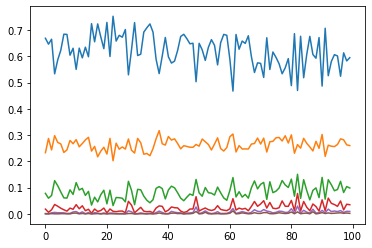

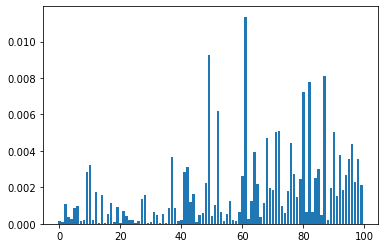

In [30]:
fwi_ukcordex = np.load('/home/theo/outdata/2.1.outdata/ukcordex_regional_fwi_severity_by_area.npy')[:,1:,0,:]
print(fwi_ukcordex.shape)
fwi_inputs = np.percentile(fwi_ukcordex,100,axis=1)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)

plt.figure()
plt.plot(fwi_inputs[0,:])
plt.plot(fwi_inputs[1,:])
plt.plot(fwi_inputs[2,:])
plt.plot(fwi_inputs[3,:])
plt.plot(fwi_inputs[4,:])
plt.plot(fwi_inputs[5,:])

plt.figure()
plt.bar(np.arange(100),fwi_inputs[5,:])

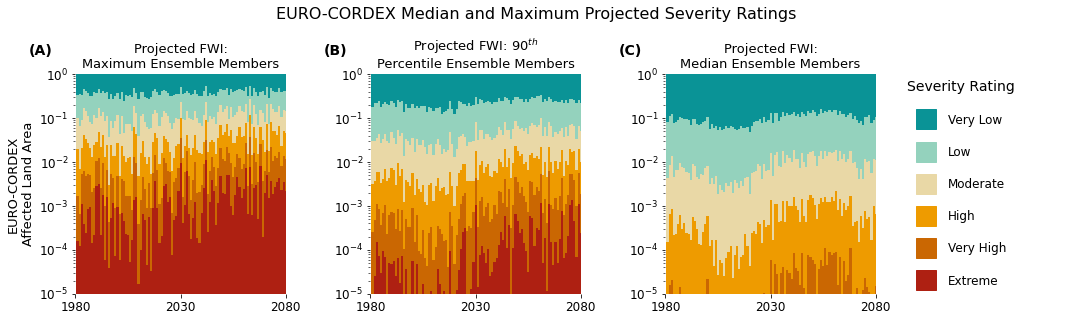

In [41]:
#fwi_ukcp = np.load('/home/theo/outdata/2.1.outdata/ukcp18_regional_fwi_severity_by_area.npy')[:,:,0,:]
fwi_ukcordex = np.load('/home/theo/outdata/2.1.outdata/ukcordex_regional_fwi_severity_by_area.npy')[:,1:,0,:]

colours = ['#0A9396','#94D2BD','#E9D8A6','#EE9B00','#CA6702','#AE2012']
markers = 6*['s']
labels = ['Very Low','Low','Moderate','High','Very High','Extreme']
handles = 6*[]

fig = plt.figure(figsize=(15, 4.5),tight_layout=True)
fig.suptitle('EURO-CORDEX Median and Maximum Projected Severity Ratings',fontsize = 16)
widths = [1,1,1,0.5]
heights = [1]
grid = fig.add_gridspec(ncols=4, nrows=1, width_ratios=widths,height_ratios=heights)

ax_1 = fig.add_subplot(grid[0])
ax_1.set_title('Projected FWI:\nMaximum Ensemble Members',fontsize=13)
ax_1.set_ylabel('EURO-CORDEX\nAffected Land Area',fontsize=13)
bottom = 100 * [0]
fwi_inputs = np.percentile(fwi_ukcordex,100,axis=1)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
for i in range(5,-1,-1):
    ax_1.bar(1981+np.arange(100),fwi_inputs[i,:], bottom=bottom, width = 1.0, color=colours[i])
    bottom = bottom + fwi_inputs[i,:]
ax_1.set_yscale('log') 
ax_1.set_ylim([0.00001,1])
ax_1.spines['right'].set_visible(False)
ax_1.spines['left'].set_visible(False)
ax_1.spines['top'].set_visible(False)
ax_1.spines['bottom'].set_visible(False)
ax_1.tick_params(labelsize=12)
ax_1.yaxis.set_ticks([10**-5,10**-4,10**-3,10**-2,10**-1,10**-0])
ax_1.xaxis.set_ticks([1980,2030,2080])
ax_1.set_xlim((1980, 2080)) 
ax_1.text(1958,2.8, '(A)', size=14,weight='bold')




ax_2 = fig.add_subplot(grid[1])
ax_2.set_title('Projected FWI: 90$^{th}$\nPercentile Ensemble Members',fontsize=13)
bottom = 100 * [0]
fwi_inputs = np.percentile(fwi_ukcordex,90,axis=1)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
for i in range(5,-1,-1):
    ax_2.bar(1981+np.arange(100),fwi_inputs[i,:], bottom=bottom, width = 1.0, color=colours[i])
    bottom = bottom + fwi_inputs[i,:]
ax_2.set_yscale('log') 
ax_2.set_ylim([0.00001,1])
ax_2.spines['right'].set_visible(False)
ax_2.spines['left'].set_visible(False)
ax_2.spines['top'].set_visible(False)
ax_2.spines['bottom'].set_visible(False)
ax_2.tick_params(labelsize=12)
ax_2.yaxis.set_ticks([10**-5,10**-4,10**-3,10**-2,10**-1,10**-0])
ax_2.xaxis.set_ticks([1980,2030,2080])
ax_2.set_xlim((1980, 2080)) 
ax_2.text(1958,2.8, '(B)', size=14,weight='bold')


ax_3 = fig.add_subplot(grid[2])
ax_3.set_title('Projected FWI:\nMedian Ensemble Members',fontsize=13)
bottom = 100 * [0]
fwi_inputs = np.percentile(fwi_ukcordex,50,axis=1)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
for i in range(5,-1,-1):
    ax_3.bar(1981+np.arange(100),fwi_inputs[i,:], bottom=bottom, width = 1.0, color=colours[i])
    bottom = bottom + fwi_inputs[i,:]
ax_3.set_yscale('log') 
ax_3.set_ylim([0.00001,1])
ax_3.spines['right'].set_visible(False)
ax_3.spines['left'].set_visible(False)
ax_3.spines['top'].set_visible(False)
ax_3.spines['bottom'].set_visible(False)
ax_3.tick_params(labelsize=12)
ax_3.yaxis.set_ticks([10**-5,10**-4,10**-3,10**-2,10**-1,10**-0])
ax_3.xaxis.set_ticks([1980,2030,2080])
ax_3.set_xlim((1980, 2080)) 
ax_3.text(1958,2.8, '(C)', size=14,weight='bold')



ax_4 = fig.add_subplot(grid[3])
handles = [mpl.lines.Line2D([], [], color=colours[i], marker='s', 
                            linestyle='None',markersize=10, 
                            label=labels[i]) for i in range(6)]
ax_4.legend(handles=handles,bbox_to_anchor=(0.0, 0.5),markerscale=2,
           title = 'Severity Rating', title_fontsize = 14,
           frameon = False, fontsize=12, loc='center',
           labelspacing=1.6)
ax_4.axis('off')


plt.tight_layout()
plt.savefig('/home/theo/final_images/2.1.images/_ukcordex_final_plot_annual')

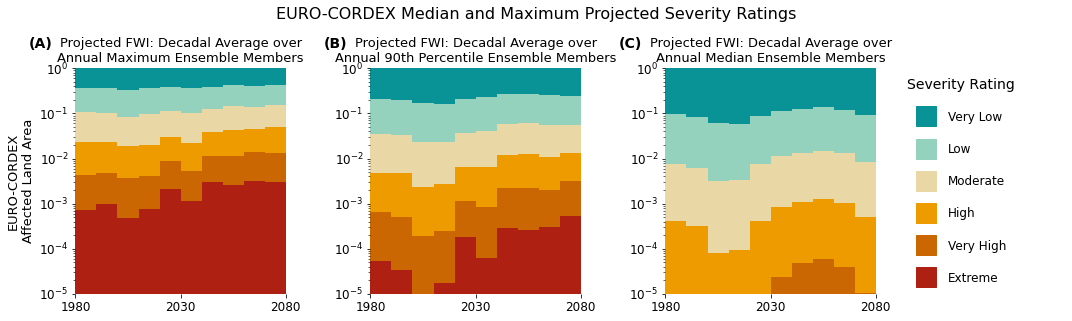

In [9]:
#fwi_ukcp = np.load('/home/theo/outdata/2.1.outdata/ukcp18_regional_fwi_severity_by_area.npy')[:,:,0,:]
fwi_ukcordex = np.load('/home/theo/outdata/2.1.outdata/ukcordex_regional_fwi_severity_by_area.npy')[:,1:,0,:]

colours = ['#0A9396','#94D2BD','#E9D8A6','#EE9B00','#CA6702','#AE2012']
markers = 6*['s']
labels = ['Very Low','Low','Moderate','High','Very High','Extreme']
handles = 6*[]

fig = plt.figure(figsize=(15, 4.5),tight_layout=True)
fig.suptitle('EURO-CORDEX Median and Maximum Projected Severity Ratings',fontsize = 16)
widths = [1,1,1,0.5]
heights = [1]
grid = fig.add_gridspec(ncols=4, nrows=1, width_ratios=widths,height_ratios=heights)

ax_1 = fig.add_subplot(grid[0])
ax_1.set_title('Projected FWI: Decadal Average over\nAnnual Maximum Ensemble Members',fontsize=13)
ax_1.set_ylabel('EURO-CORDEX\nAffected Land Area',fontsize=13)
bottom = 10 * [0]
fwi_inputs = np.percentile(fwi_ukcordex,100,axis=1)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
fwi_by_dec = np.empty((6,10))
for j in range(10):
    fwi_by_dec[:,j] = np.mean(fwi_inputs[:,j*10:(j+1)*10],axis=1)
for i in range(5,-1,-1):
    ax_1.bar(1985+np.arange(10)*10,fwi_by_dec[i,:], bottom=bottom, width = 10.0, color=colours[i])
    bottom = bottom + fwi_by_dec[i,:]
ax_1.set_yscale('log') 
ax_1.set_ylim([0.00001,1])
ax_1.spines['right'].set_visible(False)
ax_1.spines['left'].set_visible(False)
ax_1.spines['top'].set_visible(False)
ax_1.spines['bottom'].set_visible(False)
ax_1.tick_params(labelsize=12)
ax_1.yaxis.set_ticks([10**-5,10**-4,10**-3,10**-2,10**-1,10**-0])
ax_1.xaxis.set_ticks([1980,2030,2080])
ax_1.set_xlim((1980, 2080)) 
ax_1.text(1958,2.8, '(A)', size=14,weight='bold')




ax_2 = fig.add_subplot(grid[1])
ax_2.set_title('Projected FWI: Decadal Average over\nAnnual 90th Percentile Ensemble Members',fontsize=13)
bottom = 10 * [0]
fwi_inputs = np.percentile(fwi_ukcordex,90,axis=1)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
fwi_by_dec = np.empty((6,10))
for j in range(10):
    fwi_by_dec[:,j] = np.mean(fwi_inputs[:,j*10:(j+1)*10],axis=1)
for i in range(5,-1,-1):
    ax_2.bar(1985+np.arange(10)*10,fwi_by_dec[i,:], bottom=bottom, width = 10.0, color=colours[i])
    bottom = bottom + fwi_by_dec[i,:]
ax_2.set_yscale('log') 
ax_2.set_ylim([0.00001,1])
ax_2.spines['right'].set_visible(False)
ax_2.spines['left'].set_visible(False)
ax_2.spines['top'].set_visible(False)
ax_2.spines['bottom'].set_visible(False)
ax_2.tick_params(labelsize=12)
ax_2.yaxis.set_ticks([10**-5,10**-4,10**-3,10**-2,10**-1,10**-0])
ax_2.xaxis.set_ticks([1980,2030,2080])
ax_2.set_xlim((1980, 2080)) 
ax_2.text(1958,2.8, '(B)', size=14,weight='bold')


ax_3 = fig.add_subplot(grid[2])
ax_3.set_title('Projected FWI: Decadal Average over\nAnnual Median Ensemble Members',fontsize=13)
bottom = 10 * [0]
fwi_inputs = np.percentile(fwi_ukcordex,50,axis=1)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
fwi_by_dec = np.empty((6,10))
for j in range(10):
    fwi_by_dec[:,j] = np.mean(fwi_inputs[:,j*10:(j+1)*10],axis=1)
for i in range(5,-1,-1):
    ax_3.bar(1985+np.arange(10)*10,fwi_by_dec[i,:], bottom=bottom, width = 10.0, color=colours[i])
    bottom = bottom + fwi_by_dec[i,:]
ax_3.set_yscale('log') 
ax_3.set_ylim([0.00001,1])
ax_3.spines['right'].set_visible(False)
ax_3.spines['left'].set_visible(False)
ax_3.spines['top'].set_visible(False)
ax_3.spines['bottom'].set_visible(False)
ax_3.tick_params(labelsize=12)
ax_3.yaxis.set_ticks([10**-5,10**-4,10**-3,10**-2,10**-1,10**-0])
ax_3.xaxis.set_ticks([1980,2030,2080])
ax_3.set_xlim((1980, 2080)) 
ax_3.text(1958,2.8, '(C)', size=14,weight='bold')



ax_4 = fig.add_subplot(grid[3])
handles = [mpl.lines.Line2D([], [], color=colours[i], marker='s', 
                            linestyle='None',markersize=10, 
                            label=labels[i]) for i in range(6)]
ax_4.legend(handles=handles,bbox_to_anchor=(0.0, 0.5),markerscale=2,
           title = 'Severity Rating', title_fontsize = 14,
           frameon = False, fontsize=12, loc='center',
           labelspacing=1.6)
ax_4.axis('off')


plt.tight_layout()
plt.savefig('/home/theo/final_images/2.1.images/_ukcordex_final_plot')


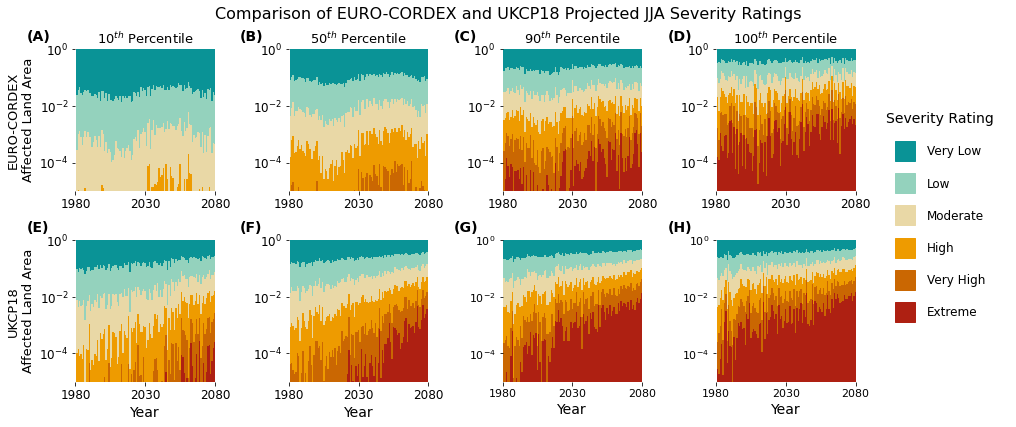

In [17]:
fwi_ukcp = np.load('/home/theo/outdata/2.1.outdata/ukcp18_regional_fwi_severity_by_area.npy')[:,:,0,:]
fwi_ukcordex = np.load('/home/theo/outdata/2.1.outdata/ukcordex_regional_fwi_severity_by_area.npy')[:,1:,0,:]
colours = ['#0A9396','#94D2BD','#E9D8A6','#EE9B00','#CA6702','#AE2012']
markers = 6*['s']
numbers = [0,90,99,99.9,99.99,99.999,100]
labels = [f'{numbers[i]} to {numbers[i+1]}%' for i in range(6)]
labels = ['Very Low','Low','Moderate','High','Very High','Extreme']
#['0-90','90-99','99-99.9','99.9-99.99','99.99-99.999','99.999-100']
handles = 6*[]


fig = plt.figure(figsize=(14, 5.5),constrained_layout=True)
fig.suptitle('Comparison of EURO-CORDEX and UKCP18 Projected JJA Severity Ratings',fontsize = 16,y=1.05)
widths = [1,1,1,1,0.5]
heights = [1, 1]
grid = fig.add_gridspec(ncols=5, nrows=2, width_ratios=widths,height_ratios=heights)


ax_1 = fig.add_subplot(grid[0,0])
ax_1.set_title('10$^{th}$ Percentile',fontsize=13)
ax_1.set_ylabel('EURO-CORDEX\nAffected Land Area',fontsize=13)
bottom = 100 * [0]
fwi_inputs = np.percentile(fwi_ukcordex,10,axis=1)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
for i in range(5,-1,-1):
    ax_1.bar(1981+np.arange(100),fwi_inputs[i,:], bottom=bottom, width = 1.0, color=colours[i])
    bottom = bottom + fwi_inputs[i,:]
ax_1.set_yscale('log') 
ax_1.set_ylim([0.00001,1])
ax_1.spines['right'].set_visible(False)
ax_1.spines['left'].set_visible(False)
ax_1.spines['top'].set_visible(False)
ax_1.spines['bottom'].set_visible(False)
ax_1.tick_params(labelsize=12)
ax_1.yaxis.set_ticks([10**-4,10**-2,10**-0])
ax_1.xaxis.set_ticks([1980,2030,2080])
ax_1.set_xlim((1980, 2080)) 
ax_1.text(1945,2, '(A)', size=14,weight='bold')


ax_2 = fig.add_subplot(grid[1,0])
ax_2.set_ylabel('UKCP18\nAffected Land Area',fontsize=13)
bottom = 100 * [0]
fwi_inputs = np.percentile(fwi_ukcp,10,axis=1)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
for i in range(5,-1,-1):
    ax_2.bar(1981+np.arange(100),fwi_inputs[i,:], bottom=bottom, width = 1.0, color=colours[i])
    bottom = bottom + fwi_inputs[i,:]
ax_2.set_xlabel('Year', fontsize = 14)
ax_2.set_yscale('log') 
ax_2.set_ylim([0.00001,1])
ax_2.spines['right'].set_visible(False)
ax_2.spines['left'].set_visible(False)
ax_2.spines['top'].set_visible(False)
ax_2.spines['bottom'].set_visible(False)
ax_2.tick_params(labelsize=12)
ax_2.yaxis.set_ticks([10**-4,10**-2,10**-0])
ax_2.xaxis.set_ticks([1980,2030,2080])
ax_2.set_xlim((1980, 2080)) 
ax_2.text(1945,2, '(E)', size=14,weight='bold')


ax_3 = fig.add_subplot(grid[0,1])
ax_3.set_title('50$^{th}$ Percentile',fontsize=13)
bottom = 100 * [0]
fwi_inputs = np.percentile(fwi_ukcordex,50,axis=1)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
for i in range(5,-1,-1):
    ax_3.bar(1981+np.arange(100),fwi_inputs[i,:], bottom=bottom, width = 1.0, color=colours[i])
    bottom = bottom + fwi_inputs[i,:]
ax_3.set_yscale('log') 
ax_3.set_ylim([0.00001,1])
ax_3.spines['right'].set_visible(False)
ax_3.spines['left'].set_visible(False)
ax_3.spines['top'].set_visible(False)
ax_3.spines['bottom'].set_visible(False)
ax_3.tick_params(labelsize=12)
ax_3.yaxis.set_ticks([10**-4,10**-2,10**-0])
ax_3.xaxis.set_ticks([1980,2030,2080])
ax_3.set_xlim((1980, 2080)) 
ax_3.text(1945,2, '(B)', size=14,weight='bold')


ax_4 = fig.add_subplot(grid[1,1])
bottom = 100 * [0]
fwi_inputs = np.percentile(fwi_ukcp,50,axis=1)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
for i in range(5,-1,-1):
    ax_4.bar(1981+np.arange(100),fwi_inputs[i,:], bottom=bottom, width = 1.0, color=colours[i])
    bottom = bottom + fwi_inputs[i,:]
ax_4.set_xlabel('Year', fontsize = 14)
ax_4.set_yscale('log') 
ax_4.set_ylim([0.00001,1])
ax_4.spines['right'].set_visible(False)
ax_4.spines['left'].set_visible(False)
ax_4.spines['top'].set_visible(False)
ax_4.spines['bottom'].set_visible(False)
ax_4.tick_params(labelsize=12)
ax_4.yaxis.set_ticks([10**-4,10**-2,10**-0])
ax_4.xaxis.set_ticks([1980,2030,2080])
ax_4.set_xlim((1980, 2080)) 
ax_4.text(1945,2, '(F)', size=14,weight='bold')


ax_5 = fig.add_subplot(grid[0,2])
ax_5.set_title('90$^{th}$ Percentile',fontsize=13)
bottom = 100 * [0]
fwi_inputs = np.percentile(fwi_ukcordex,90,axis=1)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
for i in range(5,-1,-1):
    ax_5.bar(1981+np.arange(100),fwi_inputs[i,:], bottom=bottom, width = 1.0, color=colours[i])
    bottom = bottom + fwi_inputs[i,:]
ax_5.set_yscale('log') 
ax_5.set_ylim([0.00001,1])
ax_5.spines['right'].set_visible(False)
ax_5.spines['left'].set_visible(False)
ax_5.spines['top'].set_visible(False)
ax_5.spines['bottom'].set_visible(False)
ax_5.tick_params(labelsize=12)
ax_5.yaxis.set_ticks([10**-4,10**-2,10**-0])
ax_5.xaxis.set_ticks([1980,2030,2080])
ax_5.set_xlim((1980, 2080)) 
ax_5.text(1945,2, '(C)', size=14,weight='bold')

ax_6 = fig.add_subplot(grid[1,2])
bottom = 100 * [0]
fwi_inputs = np.percentile(fwi_ukcp,90,axis=1)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
for i in range(5,-1,-1):
    ax_6.bar(1981+np.arange(100),fwi_inputs[i,:], bottom=bottom, width = 1.0, color=colours[i])
    bottom = bottom + fwi_inputs[i,:]
ax_6.set_xlabel('Year', fontsize = 14)
ax_6.set_yscale('log') 
ax_6.set_ylim([0.00001,1])
ax_6.spines['right'].set_visible(False)
ax_6.spines['left'].set_visible(False)
ax_6.spines['top'].set_visible(False)
ax_6.spines['bottom'].set_visible(False)
ax_6.tick_params(labelsize=11)
ax_6.yaxis.set_ticks([10**-4,10**-2,10**-0])
ax_6.xaxis.set_ticks([1980,2030,2080])
ax_6.set_xlim((1980, 2080)) 
ax_6.text(1945,2, '(G)', size=14,weight='bold')



ax_7 = fig.add_subplot(grid[0,3])
ax_7.set_title('100$^{th}$ Percentile',fontsize=13)
bottom = 100 * [0]
fwi_inputs = np.percentile(fwi_ukcordex,100,axis=1)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
for i in range(5,-1,-1):
    ax_7.bar(1981+np.arange(100),fwi_inputs[i,:], bottom=bottom, width = 1.0, color=colours[i])
    bottom = bottom + fwi_inputs[i,:]
ax_7.set_yscale('log') 
ax_7.set_ylim([0.00001,1])
ax_7.spines['right'].set_visible(False)
ax_7.spines['left'].set_visible(False)
ax_7.spines['top'].set_visible(False)
ax_7.spines['bottom'].set_visible(False)
ax_7.tick_params(labelsize=12)
ax_7.yaxis.set_ticks([10**-4,10**-2,10**-0])
ax_7.xaxis.set_ticks([1980,2030,2080])
ax_7.set_xlim((1980, 2080)) 
ax_7.text(1945,2, '(D)', size=14,weight='bold')

ax_8 = fig.add_subplot(grid[1,3])
bottom = 100 * [0]
fwi_inputs = np.percentile(fwi_ukcp,100,axis=1)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
for i in range(5,-1,-1):
    ax_8.bar(1981+np.arange(100),fwi_inputs[i,:], bottom=bottom, width = 1.0, color=colours[i])
    bottom = bottom + fwi_inputs[i,:]
ax_8.set_xlabel('Year', fontsize = 14)
ax_8.set_yscale('log') 
ax_8.set_ylim([0.00001,1])
ax_8.spines['right'].set_visible(False)
ax_8.spines['left'].set_visible(False)
ax_8.spines['top'].set_visible(False)
ax_8.spines['bottom'].set_visible(False)
ax_8.tick_params(labelsize=11)
ax_8.yaxis.set_ticks([10**-4,10**-2,10**-0])
ax_8.xaxis.set_ticks([1980,2030,2080])
ax_8.set_xlim((1980, 2080)) 
ax_8.text(1945,2, '(H)', size=14,weight='bold')



ax_9 = fig.add_subplot(grid[:,4])
handles = [mpl.lines.Line2D([], [], color=colours[i], marker='s', 
                            linestyle='None',markersize=10, 
                            label=labels[i]) for i in range(6)]
ax_9.legend(handles=handles,bbox_to_anchor=(0.0, 0.5),markerscale=2,
           title = 'Severity Rating', title_fontsize = 14,
           frameon = False, fontsize=12, loc='center',
           labelspacing=1.6)
ax_9.axis('off')



plt.savefig('/home/theo/final_images/2.1.images/comparison_across_ensembles_annual',bbox_inches='tight')

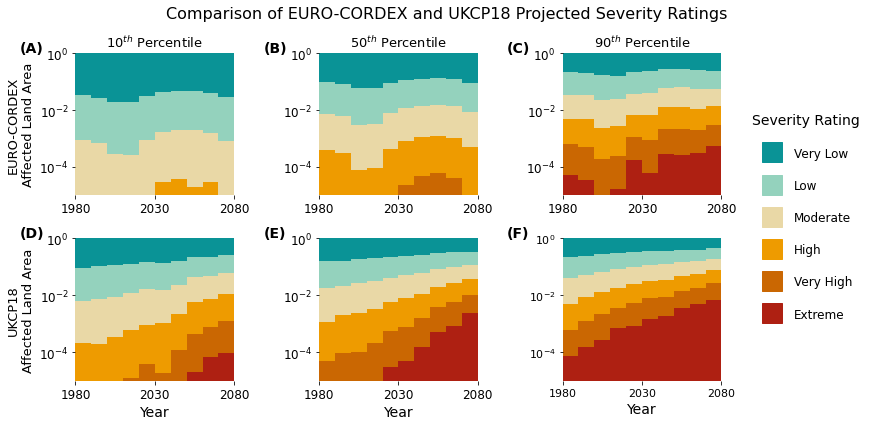

In [3]:
fwi_ukcp = np.load('/home/theo/outdata/2.1.outdata/ukcp18_regional_fwi_severity_by_area.npy')[:,:,0,:]
fwi_ukcordex = np.load('/home/theo/outdata/2.1.outdata/ukcordex_regional_fwi_severity_by_area.npy')[:,1:,0,:]
colours = ['#0A9396','#94D2BD','#E9D8A6','#EE9B00','#CA6702','#AE2012']
markers = 6*['s']
numbers = [0,90,99,99.9,99.99,99.999,100]
labels = [f'{numbers[i]} to {numbers[i+1]}%' for i in range(6)]
labels = ['Very Low','Low','Moderate','High','Very High','Extreme']
#['0-90','90-99','99-99.9','99.9-99.99','99.99-99.999','99.999-100']
handles = 6*[]


fig = plt.figure(figsize=(12.5, 6),tight_layout=True)
fig.suptitle('Comparison of EURO-CORDEX and UKCP18 Projected Severity Ratings',fontsize = 16)
widths = [1,1,1,0.5]
heights = [1, 1]
grid = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths,height_ratios=heights)


ax_1 = fig.add_subplot(grid[0,0])
ax_1.set_title('10$^{th}$ Percentile',fontsize=13)
ax_1.set_ylabel('EURO-CORDEX\nAffected Land Area',fontsize=13)
bottom = 10 * [0]
fwi_inputs = np.percentile(fwi_ukcordex,10,axis=1)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
fwi_by_dec = np.empty((6,10))
for j in range(10):
    fwi_by_dec[:,j] = np.mean(fwi_inputs[:,j*10:(j+1)*10],axis=1)
for i in range(5,-1,-1):
    ax_1.bar(1985+np.arange(10)*10,fwi_by_dec[i,:], bottom=bottom, width = 10.0, color=colours[i])
    bottom = bottom + fwi_by_dec[i,:]
ax_1.set_yscale('log') 
ax_1.set_ylim([0.00001,1])
ax_1.spines['right'].set_visible(False)
ax_1.spines['left'].set_visible(False)
ax_1.spines['top'].set_visible(False)
ax_1.spines['bottom'].set_visible(False)
ax_1.tick_params(labelsize=12)
ax_1.yaxis.set_ticks([10**-4,10**-2,10**-0])
ax_1.xaxis.set_ticks([1980,2030,2080])
ax_1.set_xlim((1980, 2080)) 
ax_1.text(1945,1.1, '(A)', size=14,weight='bold')


ax_2 = fig.add_subplot(grid[1,0])
ax_2.set_ylabel('UKCP18\nAffected Land Area',fontsize=13)
bottom = 10 * [0]
fwi_inputs = np.percentile(fwi_ukcp,10,axis=1)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
fwi_by_dec = np.empty((6,10))
for j in range(10):
    fwi_by_dec[:,j] = np.mean(fwi_inputs[:,j*10:(j+1)*10],axis=1)
for i in range(5,-1,-1):
    ax_2.bar(1985+np.arange(10)*10,fwi_by_dec[i,:], bottom=bottom, width = 10.0, color=colours[i])
    bottom = bottom + fwi_by_dec[i,:]
ax_2.set_xlabel('Year', fontsize = 14)
ax_2.set_yscale('log') 
ax_2.set_ylim([0.00001,1])
ax_2.spines['right'].set_visible(False)
ax_2.spines['left'].set_visible(False)
ax_2.spines['top'].set_visible(False)
ax_2.spines['bottom'].set_visible(False)
ax_2.tick_params(labelsize=12)
ax_2.yaxis.set_ticks([10**-4,10**-2,10**-0])
ax_2.xaxis.set_ticks([1980,2030,2080])
ax_2.set_xlim((1980, 2080)) 
ax_2.text(1945,1.1, '(D)', size=14,weight='bold')


ax_3 = fig.add_subplot(grid[0,1])
ax_3.set_title('50$^{th}$ Percentile',fontsize=13)
bottom = 10 * [0]
fwi_inputs = np.percentile(fwi_ukcordex,50,axis=1)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
fwi_by_dec = np.empty((6,10))
for j in range(10):
    fwi_by_dec[:,j] = np.mean(fwi_inputs[:,j*10:(j+1)*10],axis=1)
for i in range(5,-1,-1):
    ax_3.bar(1985+np.arange(10)*10,fwi_by_dec[i,:], bottom=bottom, width = 10.0, color=colours[i])
    bottom = bottom + fwi_by_dec[i,:]
ax_3.set_yscale('log') 
ax_3.set_ylim([0.00001,1])
ax_3.spines['right'].set_visible(False)
ax_3.spines['left'].set_visible(False)
ax_3.spines['top'].set_visible(False)
ax_3.spines['bottom'].set_visible(False)
ax_3.tick_params(labelsize=12)
ax_3.yaxis.set_ticks([10**-4,10**-2,10**-0])
ax_3.xaxis.set_ticks([1980,2030,2080])
ax_3.set_xlim((1980, 2080)) 
ax_3.text(1945,1.1, '(B)', size=14,weight='bold')


ax_4 = fig.add_subplot(grid[1,1])
bottom = 10 * [0]
fwi_inputs = np.percentile(fwi_ukcp,50,axis=1)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
fwi_by_dec = np.empty((6,10))
for j in range(10):
    fwi_by_dec[:,j] = np.mean(fwi_inputs[:,j*10:(j+1)*10],axis=1)
for i in range(5,-1,-1):
    ax_4.bar(1985+np.arange(10)*10,fwi_by_dec[i,:], bottom=bottom, width = 10.0, color=colours[i])
    bottom = bottom + fwi_by_dec[i,:]
ax_4.set_xlabel('Year', fontsize = 14)
ax_4.set_yscale('log') 
ax_4.set_ylim([0.00001,1])
ax_4.spines['right'].set_visible(False)
ax_4.spines['left'].set_visible(False)
ax_4.spines['top'].set_visible(False)
ax_4.spines['bottom'].set_visible(False)
ax_4.tick_params(labelsize=12)
ax_4.yaxis.set_ticks([10**-4,10**-2,10**-0])
ax_4.xaxis.set_ticks([1980,2030,2080])
ax_4.set_xlim((1980, 2080)) 
ax_4.text(1945,1.1, '(E)', size=14,weight='bold')


ax_5 = fig.add_subplot(grid[0,2])
ax_5.set_title('90$^{th}$ Percentile',fontsize=13)
bottom = 10 * [0]
fwi_inputs = np.percentile(fwi_ukcordex,90,axis=1)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
fwi_by_dec = np.empty((6,10))
for j in range(10):
    fwi_by_dec[:,j] = np.mean(fwi_inputs[:,j*10:(j+1)*10],axis=1)
for i in range(5,-1,-1):
    ax_5.bar(1985+np.arange(10)*10,fwi_by_dec[i,:], bottom=bottom, width = 10.0, color=colours[i])
    bottom = bottom + fwi_by_dec[i,:]
ax_5.set_yscale('log') 
ax_5.set_ylim([0.00001,1])
ax_5.spines['right'].set_visible(False)
ax_5.spines['left'].set_visible(False)
ax_5.spines['top'].set_visible(False)
ax_5.spines['bottom'].set_visible(False)
ax_5.tick_params(labelsize=12)
ax_5.yaxis.set_ticks([10**-4,10**-2,10**-0])
ax_5.xaxis.set_ticks([1980,2030,2080])
ax_5.set_xlim((1980, 2080)) 
ax_5.text(1945,1.1, '(C)', size=14,weight='bold')

ax_6 = fig.add_subplot(grid[1,2])
bottom = 10 * [0]
fwi_inputs = np.percentile(fwi_ukcp,90,axis=1)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
fwi_by_dec = np.empty((6,10))
for j in range(10):
    fwi_by_dec[:,j] = np.mean(fwi_inputs[:,j*10:(j+1)*10],axis=1)
for i in range(5,-1,-1):
    ax_6.bar(1985+np.arange(10)*10,fwi_by_dec[i,:], bottom=bottom, width = 10.0, color=colours[i])
    bottom = bottom + fwi_by_dec[i,:]
ax_6.set_xlabel('Year', fontsize = 14)
ax_6.set_yscale('log') 
ax_6.set_ylim([0.00001,1])
ax_6.spines['right'].set_visible(False)
ax_6.spines['left'].set_visible(False)
ax_6.spines['top'].set_visible(False)
ax_6.spines['bottom'].set_visible(False)
ax_6.tick_params(labelsize=11)
ax_6.yaxis.set_ticks([10**-4,10**-2,10**-0])
ax_6.xaxis.set_ticks([1980,2030,2080])
ax_6.set_xlim((1980, 2080)) 
ax_6.text(1945,1.1, '(F)', size=14,weight='bold')

ax_7 = fig.add_subplot(grid[:,3])
handles = [mpl.lines.Line2D([], [], color=colours[i], marker='s', 
                            linestyle='None',markersize=10, 
                            label=labels[i]) for i in range(6)]
ax_7.legend(handles=handles,bbox_to_anchor=(0.0, 0.5),markerscale=2,
           title = 'Severity Rating', title_fontsize = 14,
           frameon = False, fontsize=12, loc='center',
           labelspacing=1.6)
ax_7.axis('off')


plt.tight_layout()
plt.savefig('/home/theo/final_images/2.1.images/comparison_across_ensembles')

In [41]:
fwi_ukcp = np.load('/home/theo/outdata/2.1.outdata/ukcp18_regional_fwi_severity_by_area.npy')[:,:,0,:]
fwi_ukcordex = np.load('/home/theo/outdata/2.1.outdata/ukcordex_regional_fwi_severity_by_area.npy')[:,1:,0,:]
fwi_ukcp = fwi_ukcp/np.sum(fwi_ukcp,axis=0)
fwi_ukcordex = fwi_ukcordex/np.sum(fwi_ukcordex,axis=0)

print('\nEURO-CORDEX:')
N = 100
print(f'{N}th Percentile:')
fwi_inputs = np.percentile(fwi_ukcordex,N,axis=1)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
fwi_first_20 = np.average(fwi_inputs[:,:20],axis=1)
fwi_last_20  = np.average(fwi_inputs[:,-20:],axis=1)
fwi_ratio = fwi_last_20 / fwi_first_20
print(fwi_ratio)
N = 90
print(f'{N}th Percentile:')
fwi_inputs = np.percentile(fwi_ukcordex,N,axis=1)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
fwi_first_20 = np.average(fwi_inputs[:,:20],axis=1)
fwi_last_20  = np.average(fwi_inputs[:,-20:],axis=1)
fwi_ratio = fwi_last_20 / fwi_first_20
print(fwi_ratio)
N = 50
print(f'{N}th Percentile:')
fwi_inputs = np.percentile(fwi_ukcordex,N,axis=1)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
fwi_first_20 = np.average(fwi_inputs[:,:20],axis=1)
fwi_last_20  = np.average(fwi_inputs[:,-20:],axis=1)
fwi_ratio = fwi_last_20 / fwi_first_20
print(fwi_ratio)
print(f'Mean-Median Ratio')
fwi_inputs_1 = np.mean(np.mean(fwi_ukcordex,axis=1),axis=1)
fwi_inputs_2 = np.median(np.median(fwi_ukcordex,axis=1),axis=1)
fwi_ratio = fwi_inputs_1 / fwi_inputs_2
print(fwi_ratio)
print('Number of 0 occurence extreme years')
print(np.sum(fwi_ukcordex[5,:,:] == 0)/4800)


print('\nUKCP18:')
N = 100
print(f'{N}th Percentile:')
fwi_inputs = np.percentile(fwi_ukcp,N,axis=1)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
fwi_first_20 = np.average(fwi_inputs[:,:20],axis=1)
fwi_last_20  = np.average(fwi_inputs[:,-20:],axis=1)
fwi_ratio = fwi_last_20 / fwi_first_20
print(fwi_ratio)
N = 90
print(f'{N}th Percentile:')
fwi_inputs = np.percentile(fwi_ukcp,N,axis=1)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
fwi_first_20 = np.average(fwi_inputs[:,:20],axis=1)
fwi_last_20  = np.average(fwi_inputs[:,-20:],axis=1)
fwi_ratio = fwi_last_20 / fwi_first_20
print(fwi_ratio)
N = 50
print(f'{N}th Percentile:')
fwi_inputs = np.percentile(fwi_ukcp,N,axis=1)
fwi_inputs = fwi_inputs/np.sum(fwi_inputs,axis=0)
fwi_first_20 = np.average(fwi_inputs[:,:20],axis=1)
fwi_last_20  = np.average(fwi_inputs[:,-20:],axis=1)
fwi_ratio = fwi_last_20 / fwi_first_20
print(fwi_ratio)
print(f'Mean-Median Ratio')
fwi_inputs_1 = np.mean(np.mean(fwi_ukcp,axis=1),axis=1)
fwi_inputs_2 = np.median(np.median(fwi_ukcp,axis=1),axis=1)
fwi_ratio = fwi_inputs_1 / fwi_inputs_2
print(fwi_ratio)
print('Number of 0 occurence extreme years')
print(np.sum(fwi_ukcp[5,:,:] == 0)/4800)


EURO-CORDEX:
100th Percentile:
[0.96556554 0.98493746 1.19499264 1.71838361 2.51972454 3.59704108]
90th Percentile:
[0.96051592 1.10547044 1.45059233 2.19101179 3.78807033 9.12801101]
50th Percentile:
[0.98099012 1.16086251 1.56220126 2.05403986 4.81523525        inf]
Mean-Median Ratio
[ 0.97843699  1.14081193  1.92121063  5.80650716 65.45279597         inf]
Number of 0 occurence extreme years
0.715625

UKCP18:
100th Percentile:
[ 0.82556562  1.16389815  2.01679166  3.90605587  7.60399217 15.29292152]
90th Percentile:
[ 0.80626559  1.25507079  2.70025824  7.13542292 19.75509472 46.41563724]
50th Percentile:
[7.91294006e-01 1.61102563e+00 4.34376947e+00 1.56740944e+01
 8.82820304e+01 3.01476440e+03]
Mean-Median Ratio
[ 0.99161291  0.95976325  1.16749969  2.07858369  5.79835586 52.19979838]
Number of 0 occurence extreme years
0.088125


<ipython-input-41-c196f09fe49c>:29: RuntimeWarning: divide by zero encountered in true_divide
  fwi_ratio = fwi_last_20 / fwi_first_20
<ipython-input-41-c196f09fe49c>:34: RuntimeWarning: divide by zero encountered in true_divide
  fwi_ratio = fwi_inputs_1 / fwi_inputs_2


In [44]:
fwi_ukcp = np.load('/home/theo/outdata/2.1.outdata/ukcp18_regional_fwi_severity_by_area.npy')[:,:,0,:]
fwi_ukcordex = np.load('/home/theo/outdata/2.1.outdata/ukcordex_regional_fwi_severity_by_area.npy')[:,1:,0,:]
fwi_ukcp = fwi_ukcp/np.sum(fwi_ukcp,axis=0)
fwi_ukcordex = fwi_ukcordex/np.sum(fwi_ukcordex,axis=0)


print('1981-2000 Differences in Proportions between ensembles')
# 10th
cord_data = np.mean(np.percentile(fwi_ukcordex[:,:,:20],10,axis=1),axis=1)
ukcp_data = np.mean(np.percentile(fwi_ukcp[:,:,:20],10,axis=1),axis=1)
print('10th Percentile:')
ratio_dat = ukcp_data / cord_data
print(ratio_dat)
# 50th
cord_data = np.mean(np.percentile(fwi_ukcordex[:,:,:20],50,axis=1),axis=1)
ukcp_data = np.mean(np.percentile(fwi_ukcp[:,:,:20],50,axis=1),axis=1)
print('50th Percentile:')
ratio_dat = ukcp_data / cord_data
print(ratio_dat)
# 90th
cord_data = np.mean(np.percentile(fwi_ukcordex[:,:,:20],90,axis=1),axis=1)
ukcp_data = np.mean(np.percentile(fwi_ukcp[:,:,:20],90,axis=1),axis=1)
print('90th Percentile:')
ratio_dat = ukcp_data / cord_data
print(ratio_dat)
# 100th
cord_data = np.mean(np.percentile(fwi_ukcordex[:,:,:20],100,axis=1),axis=1)
ukcp_data = np.mean(np.percentile(fwi_ukcp[:,:,:20],100,axis=1),axis=1)
print('100th Percentile:')
ratio_dat = ukcp_data / cord_data
print(ratio_dat)
print('\n\n\n')



print('2061-2080 Differences in Proportions between ensembles')
# 10th
cord_data = np.mean(np.percentile(fwi_ukcordex[:,:,-20:],10,axis=1),axis=1)
ukcp_data = np.mean(np.percentile(fwi_ukcp[:,:,-20:],10,axis=1),axis=1)
print('10th Percentile:')
ratio_dat = ukcp_data / cord_data
print(ratio_dat)
# 50th
cord_data = np.mean(np.percentile(fwi_ukcordex[:,:,-20:],50,axis=1),axis=1)
ukcp_data = np.mean(np.percentile(fwi_ukcp[:,:,-20:],50,axis=1),axis=1)
print('50th Percentile:')
ratio_dat = ukcp_data / cord_data
print(ratio_dat)
# 90th
cord_data = np.mean(np.percentile(fwi_ukcordex[:,:,-20:],90,axis=1),axis=1)
ukcp_data = np.mean(np.percentile(fwi_ukcp[:,:,-20:],90,axis=1),axis=1)
print('90th Percentile:')
ratio_dat = ukcp_data / cord_data
print(ratio_dat)
# 100th
cord_data = np.mean(np.percentile(fwi_ukcordex[:,:,-20:],100,axis=1),axis=1)
ukcp_data = np.mean(np.percentile(fwi_ukcp[:,:,-20:],100,axis=1),axis=1)
print('100th Percentile:')
ratio_dat = ukcp_data / cord_data
print(ratio_dat)


1981-2000 Differences in Proportions between ensembles
10th Percentile:
[ 0.96358807  3.30038703  8.48239063 48.67064187         inf         nan]
50th Percentile:
[ 0.92360554  1.68717113  2.7931558   4.18492522 14.26273239         inf]
90th Percentile:
[0.92450746 1.10316772 1.34941755 1.4337539  1.48499936 2.67905676]
100th Percentile:
[0.93563579 0.82479968 0.75734149 0.7094628  0.66705892 0.60495109]




2061-2080 Differences in Proportions between ensembles
10th Percentile:
[  0.76751747   5.68933301  37.42068208 468.91147126          inf
          inf]
50th Percentile:
[7.46043873e-01 2.34486125e+00 7.77892827e+00 3.20146167e+01
 2.62320582e+02 1.30731920e+04]
90th Percentile:
[ 0.78385068  1.26366131  2.52326849  4.67985364  7.72425547 13.53616504]
100th Percentile:
[0.81397293 0.9861605  1.28116995 1.59504513 1.97514595 2.5208285 ]
100th cordex to 50th UKCP
[0.6114753  1.11363158 1.38969668 1.48197348 1.11564714 0.76807198]


<ipython-input-44-8f3bb14bdf00>:12: RuntimeWarning: divide by zero encountered in true_divide
  ratio_dat = ukcp_data / cord_data
<ipython-input-44-8f3bb14bdf00>:12: RuntimeWarning: invalid value encountered in true_divide
  ratio_dat = ukcp_data / cord_data
<ipython-input-44-8f3bb14bdf00>:18: RuntimeWarning: divide by zero encountered in true_divide
  ratio_dat = ukcp_data / cord_data
<ipython-input-44-8f3bb14bdf00>:41: RuntimeWarning: divide by zero encountered in true_divide
  ratio_dat = ukcp_data / cord_data


In [55]:
new_test = 50
index_i = 0
index_j = 0
for j in range(100,0,-1):
    cord_data = np.mean(np.percentile(fwi_ukcordex[:,:,-20:],100,axis=1),axis=1)
    ukcp_data = np.mean(np.percentile(fwi_ukcp[:,:,-20:],j,axis=1),axis=1)
    test = np.abs(np.average(ukcp_data / cord_data) - 1)
    if test < new_test:
        new_test = test
        index_j = j
    
cord_data = np.mean(np.percentile(fwi_ukcordex[:,:,-20:],100,axis=1),axis=1)
ukcp_data = np.mean(np.percentile(fwi_ukcp[:,:,-20:],index_j,axis=1),axis=1)
#print(index_i)
print(index_j)
print(ukcp_data/cord_data)

77
[0.73362189 0.90607095 1.03627707 1.1286677  1.14246372 1.04528634]
